# Séries temporelles des prix

Pour chaque appartement, nous avons une série de prix pour une date donnée. L'objectif est d'étudier les séries temporelles des prix et de pouvoir effectuer des opérations dessus.

Une série temporelle est défini comme un processus discret $(X_t)_{t \in \mathbb{N}}$ à valeurs dans $\mathbb{R}$. Ici, on associe à chaque appartement une série temporelle, et le prix à la date $t$ se note $X_t$.

## Chargement des données

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime

In [17]:
prices = pd.read_csv("../clean/prices.csv").set_index('listing_id')
listings = pd.read_csv("../clean/listings.csv").set_index('listing_id')
print("Chargement des données effectué.")

Chargement des données effectué.


Regardons quelques observations

In [18]:
prices.iloc[:10, :]

,day,available,local_price,min_nights
listing_id,,,,
5396,2018-08-27,False,103,2
5396,2018-08-28,False,103,2
5396,2018-08-29,False,103,2
5396,2018-08-30,False,103,2
5396,2018-08-31,False,103,2
5396,2018-09-01,False,103,2
5396,2018-09-02,False,103,2
5396,2018-09-03,False,103,2
5396,2018-09-04,False,103,2


## Sélection des appartements

In [19]:
uniques, counts = np.unique(prices.index, return_counts=True)  # On récupère les ID uniques et leur occurences sur les prix
intersects = np.intersect1d(uniques, np.unique(listings.index))
print(counts) # On regarde globalement combien de prix on a pour chaque appartement
print(len(intersects))  # On vérifie que l'on a bien tous nos appartements de listings

[133 132 131 ... 132 133 133]
999


> Pourquoi ici n'a-t-on pas utilisé une jointure ?

On prends le sous-ensemble de prix faisant référence à des appartements listés dans le jeu de données.

In [20]:
listings_prices = prices[prices.index.isin(intersects)]
listings_prices.iloc[:10, :]

,day,available,local_price,min_nights
listing_id,,,,
56093,2018-08-27,False,170,4
56093,2018-08-28,False,170,4
56093,2018-08-29,False,170,4
56093,2018-08-30,False,170,4
56093,2018-08-31,False,170,4
56093,2018-09-01,False,170,4
56093,2018-09-02,False,170,4
56093,2018-09-03,False,170,4
56093,2018-09-04,False,170,4


## Visualisation simple
On va afficher un appartement pour visualiser la courbe du prix.

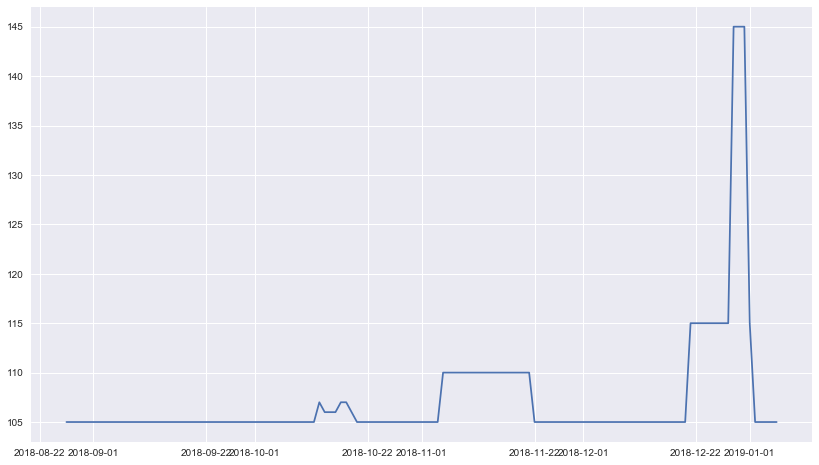

In [21]:
plt.figure(figsize=(14, 8))  # Affichage plus grand dans le notebook
ID = intersects[2]
series = listings_prices[listings_prices.index == ID]  # On récupère au bon ID
dates = np.asarray([ datetime.strptime(x, "%Y-%m-%d") for x in series["day"].values ])  # Les dates pour un bel affichage
I_sort = np.argsort(dates)
plt.plot(dates[I_sort], series["local_price"].values[I_sort])
plt.show()

## Quelques exemples

Essayez d'afficher la courbe de prix de différents appartements parmi les 20 premiers et réutilisant le code précédent dans une fonction pour rendre la manipulation plus facile.

In [ ]:
# TODO : Créer une fonction plot_prices qui en fonction de l'ID d'un appartement, affiche la série des prix
def plot_price(idx):
    # ...
    
plot_price(2581464)

## Transformations des séries
Parmi les séries affichées précedemment, on distingue trois cas particuliers :

- Des séries bruitées, c'est-à-dire avec beaucoup d'aléas visibles
- Des valeurs extrêmes, des "pics" (positifs ou négatifs) de prix très concentrés sur un court laps de temps
- Des motifs de décomposition saisonnière (motifs répétés à chaque période)

Nous allons appliquer plusieurs traitements afin de rendre les séries plus cohérentes pour la modélisation.

### Moyenne mobiles

L'objectif de la moyenne mobile est de moyenne le prix d'une date $t$ avec les prix à des dates voisines. Cette transformation permet de "lisser" les séries et donc de rendre la série moins sensible aux valeurs extrêmes.

On crée une série temporelle $(Y_t)$ à partir de $(X_t)$ de la manière suivante :
$$Y_t=\frac{1}{2k+1} \sum_{l=t-k}^{t+k} X_l$$
$(Y_t)$ s'appelle donc la moyenne mobile **d'ordre $k$**, $k$ étant le nombre de voisins à gauche (et à droite) que l'on considère pour moyenner.

In [23]:
series.iloc[I_sort, :]["local_price"].rolling(3).mean()

listing_id
114543           NaN
114543           NaN
114543    105.000000
114543    105.000000
114543    105.000000
             ...    
114543    121.666667
114543    108.333333
114543    105.000000
114543    105.000000
114543    105.000000
Name: local_price, Length: 133, dtype: float64

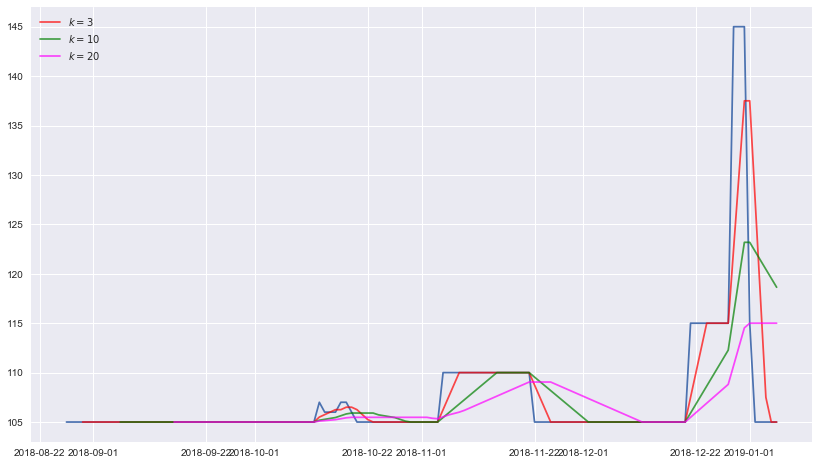

In [24]:
plt.figure(figsize=(14, 8))  # Affichage plus grand dans le notebook
ID = intersects[2]
series = listings_prices[listings_prices.index == ID]  # On récupère au bon ID
plt.plot(dates[I_sort], series["local_price"].values[I_sort], alpha=1)
colors = ["red", "green", "magenta"]
for k in [3, 10, 20]:
    # TODO : Calculer la moyenne (dans la variable mean_average) à l'aide de la fonction rolling dans pandas
    mean_average = ...
    dates = np.asarray([ datetime.strptime(x, "%Y-%m-%d") for x in series["day"].values ])  # Les dates pour un bel affichage
    I_sort = np.argsort(dates)
    plt.plot(dates[I_sort], mean_average, color=colors[k % 3], label="$k={0}$".format(k), alpha=0.7)
plt.legend()
plt.show()

### Valeurs extrêmes

Une valeur extrême est une valeurs qui se situe parmi les plus grandes valeurs de la série. En particulier, certaines valeurs extrêmes peuvent être des valeurs aberrantes, des pics de prix bien trop élevés par rapport à la moyenne. On peut utiliser plusieurs méthodes :

- Méthode des blocks maximas (aggrégation des valeurs par maximum sur chaque période)
- Méthode à seuillage (Point Over Threshold, Mean Excess, ...)
- Estimateurs Quantile-Quantile
- Intervalle de confiance

Pour notre cas d'usage, on s'arrêtera à l'utilisateur de boites à moustaches et de sélection par intervalle de confiance.

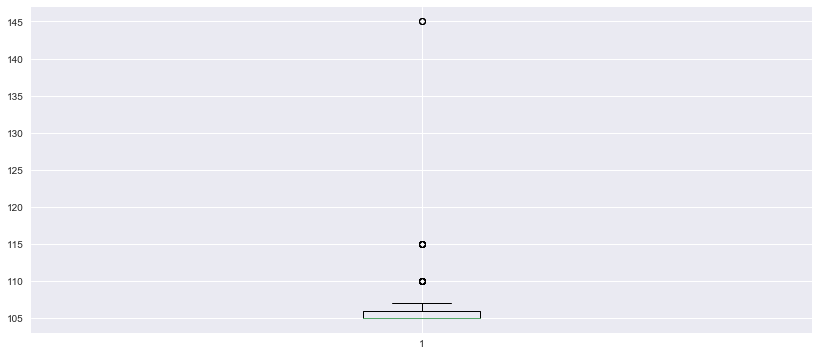

In [25]:
plt.figure(figsize=(14, 6))
ID = intersects[2]
series = listings_prices[listings_prices.index == ID]
# TODO : Afficher la boîte à moustache

plt.show()

D'après ce graphique, on souhaite retirer la valeur à $145$. Seulement, en retirant cette valeur, on obtient une série avec "un vide" à la place (sous Python, cela s'appelle des NaN pour Not a Number). Il faut donc remplacer ces vides par une valeur numérique.

Le schéma classique consiste à effectuer une **interpolation linéaire** : on va tracer une droite qui relie le dernier point avant le vide, et le premier point après. Ainsi, pour chaque valeur retirée, on la remplace par la coordonnée de la droite d'interpolation au temps correspondant.

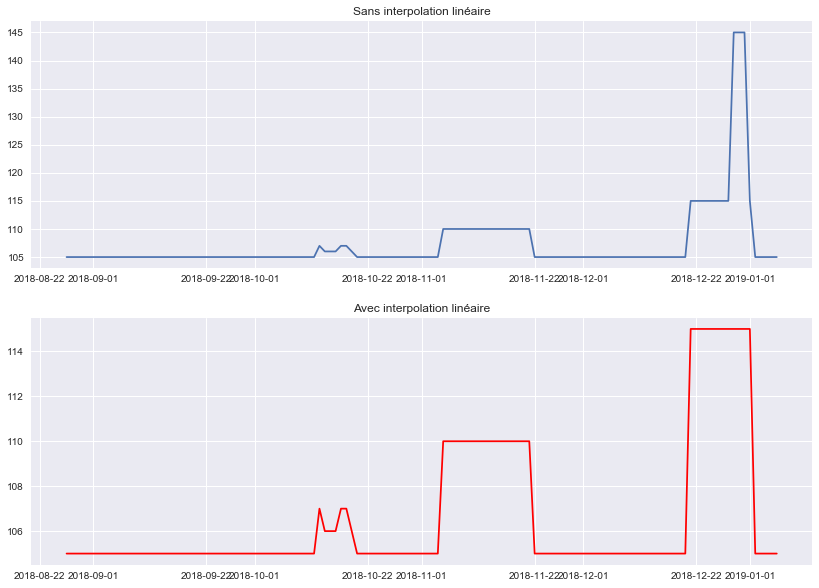

In [27]:
from scipy import interpolate

plt.figure(figsize=(14, 10))  # Affichage plus grand dans le notebook
plt.subplot(211)
ID = intersects[2]
series = listings_prices[listings_prices.index == ID]  # On récupère au bon ID
dates = np.asarray([ datetime.strptime(x, "%Y-%m-%d") for x in series["day"].values ])  # Les dates pour un bel affichage
I_sort = np.argsort(dates)
# Processus d'interpolation
local_prices_interpolate = series["local_price"].copy()
local_prices_interpolate[local_prices_interpolate > 140] = np.nan
local_prices_interpolate = pd.Series(local_prices_interpolate).iloc[I_sort].interpolate().values
#
plt.title("Sans interpolation linéaire")
plt.plot(dates[I_sort], series["local_price"].values[I_sort])
plt.subplot(212)
plt.title("Avec interpolation linéaire")
plt.plot(dates[I_sort], local_prices_interpolate, color="red")
plt.show()

> Une valeur extrême est-elle une valeur aberrante ? Dans quels cas doit-on considérer une valeur extrême comme aberrante ?

## Regroupement par plages de dates

Revenons sur notre objectif initial : estimer un prix d'un appartement à un instant $t$ ($t$ étant supérieur ou égal au temps présent). Nous avons vu que le prix n'est pas linéaire en fonction de la date (vacances, Noël, nouvel an, ...).

Nous avons vu que pour les arbres CART, utiliser uniquement le jour ramène à utiliser près de $365$ modalités pour la variable date, ce qui peut perturber le modèle au vu des instabilités présentes dans le jeu de données. Pour simplifier, nous allons donc agréger le prix par plage de $7$ jours dans un premier temps, ce qui nous ramène à une variable à $52$ modalités.

In [48]:
listings_prices.loc[:, 'listing_id'] = listings_prices.index
dates = pd.to_datetime(listings_prices["day"], format='%Y-%m-%d')
week_prices = listings_prices.assign(date=dates).set_index(dates).groupby(['listing_id', pd.Grouper(key='date', freq='7D')]).mean().reset_index().loc[:, ["listing_id", "date", "local_price"]]
week_prices.head()

,listing_id,date,local_price
0,56093,2018-08-27,170.0
1,56093,2018-09-03,170.0
2,56093,2018-09-10,170.0
3,56093,2018-09-17,170.0
4,56093,2018-09-24,170.0


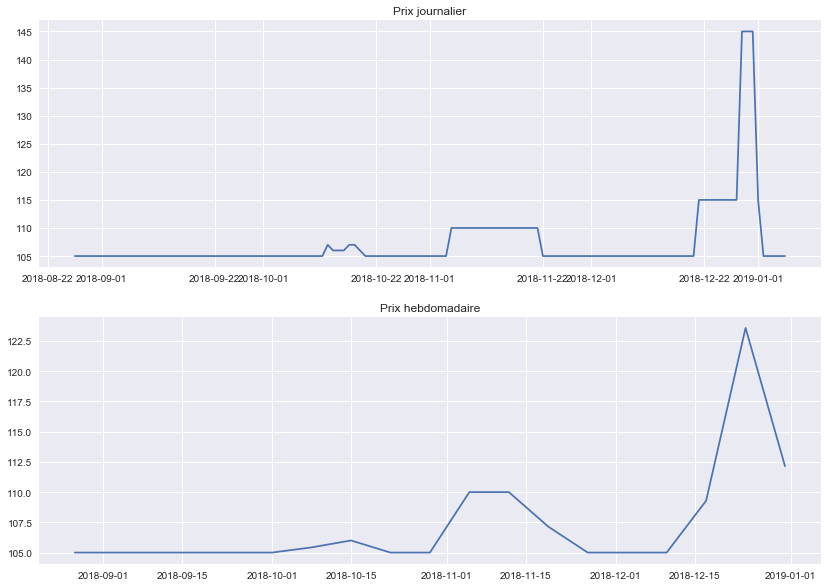

In [50]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
ID = intersects[2]
series = listings_prices[listings_prices["listing_id"] == ID]  # On récupère au bon ID
dates = np.asarray([ datetime.strptime(x, "%Y-%m-%d") for x in series["day"].values ])  # Les dates pour un bel affichage
I_sort = np.argsort(dates)

plt.title("Prix journalier")
plt.plot(dates[I_sort], series["local_price"].values[I_sort])

series = week_prices[week_prices["listing_id"] == ID]
dates = np.asarray([ x for x in series["date"].values ])
I_sort = np.argsort(dates)

plt.subplot(212)
plt.title("Prix hebdomadaire")
plt.plot(dates[I_sort], series["local_price"].values[I_sort])
plt.show()